# tf_guide_tensorflow_basics_001_overview
- https://www.tensorflow.org/guide/basics

In [1]:
import numpy as np
import tensorflow as tf

## Operator

- list型を演算にいれれば、出力は自動的にTensorになる
- `tf.constant`に入れればそのまま変換できる。
- numpy配列も同様に。

In [2]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


- numpyのように演算可能

In [3]:
print(x + x)
print(5 * x)

tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 5. 10. 15.]
 [20. 25. 30.]], shape=(2, 3), dtype=float32)


- 転置

In [4]:
tf.transpose(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

- 行列積

In [5]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

- 連結

In [6]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

- softmax

In [7]:
tf.nn.softmax(x, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.6652409 ],
       [0.09003057, 0.24472848, 0.6652409 ]], dtype=float32)>

- すべての合計

In [8]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

- tensorからnumpyへ戻す場合はこのようにする。

In [9]:
# Tensor から numpy の値を得る
print(x.numpy())

[[1. 2. 3.]
 [4. 5. 6.]]


- GPU使用状況確認

In [10]:
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow **IS** using the GPU")
else:
    print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU


## Variable
- Tensorはimmutable(変更不可能)です。
- なので学習する重みなど変更する数値はVariableを使います。

In [11]:
print(x)
var = tf.Variable(x)
print(var)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>


In [12]:
var.assign([[1, 2, 3],[4, 5, 6]])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [13]:
var.assign_add([[1,1,1],[1,1,1]])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[2., 3., 4.],
       [5., 6., 7.]], dtype=float32)>

## Automatic differentiation(自動微分)
- 勾配降下法のために、tensorflowは自動微分を実行することができる。
- 一般的には、損失関数をモデルパラメータで微分したものを得る。

In [14]:
def f(x):
    y = x**2 + 2*x - 5
    return y

x = tf.Variable(1.0)
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

- `tf.GradientTape`というcontextでラップすることで微分を記録できる。

In [15]:
with tf.GradientTape() as tape:
    y = f(x)

g_x = tape.gradient(y, x)
g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

- 以下のような場合、微分値はNoneで返却される。
  - VariableではなくTensorを使った変数
  - `with tf.GradientTape()`内でyと接続されなかった変数

In [16]:
x2 = tf.constant(1.0)
print(x2)
x3 = tf.Variable(1.0)
print(x3)

tf.Tensor(1.0, shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [17]:
with tf.GradientTape() as tape:
    y = f(x+x2)

g_x = tape.gradient(y, [x, x2, x3])
print(g_x)

[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, None, None]


- もう一度gradientを計算することはできないので、複数の変数で微分する場合は、上記のように配列で与える。

In [18]:
try:
    g_x = tape.gradient(y, [x, x2, x3])
    print(g_x)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


## tf.functionデコレータ

- `@tf.function`により学習と推論のパフォーマンスを最適化することができます。
- `tf.saved_model`を使いモデルをエクスポートすれば、Pythonがなくとも他システムで実行することが可能です。
  - ここに詳しく記載がある。https://www.tensorflow.org/guide/saved_model
  - TFLite, TensorFlow.js, TensorFlow Serving, or TensorFlow Hubを使えば、ということのように見える。

In [19]:
@tf.function
def my_func(x):
    print('Tracing.\n')
    return tf.reduce_sum(x)

- 初回は通常のPython実行と同様の動作となります。
- この時に、最適化されたグラフを生成します。

In [20]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

- 次回以降は、最適化されたグラフのみを実行します。
- print分はtensorflowの処理ではないためスキップされます。

In [21]:
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

- グラフは、入力されるshapeやdtypeが変化すると新しく生成されます。
- 新しく生成された場合でも、以前のグラフは残ります。

In [22]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

## Modules, layers and models

- 自作のModuleは以下のように`tf.Module`を継承して作成します。

In [23]:
class MyModule(tf.Module):
    def __init__(self, value):
        self.weight = tf.Variable(value)

    @tf.function
    def multiply(self, x):
        return x * self.weight

In [24]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

- Moduleは以下のように保存ができます。

In [25]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved\assets


- 出力されたモデルは、コードと独立しており、Tensorflow Serving, Tensorflow Lite, TensorFlow JSから呼び出すことが可能です。

In [26]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

- `tf.keras.layers`や`tf.keras.Model`は、この`tf.Module`をベースに提供されています。

## Training loops

- 実際の学習として線形モデルの構築をやる。

In [27]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

- ground truthに正規分布のノイズを乗せたデータを作成。

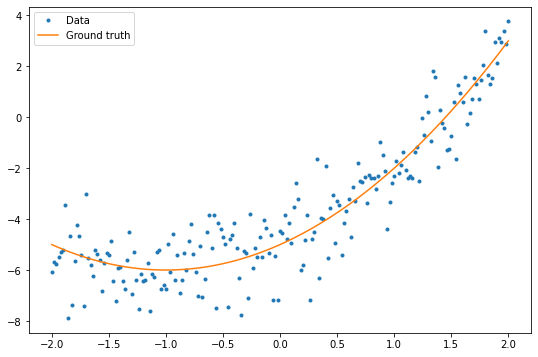

In [28]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x),  label='Ground truth')
plt.legend();

In [29]:
class Model(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=units,
                                            activation=tf.nn.relu,
                                            kernel_initializer=tf.random.normal,
                                            bias_initializer=tf.random.normal)
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        # For Keras layers/models, implement `call` instead of `__call__`.
        x = x[:, tf.newaxis]
        x = self.dense1(x)
        x = self.dense2(x)
        return tf.squeeze(x, axis=1)

In [30]:
model = Model(64)

- 学習前のモデル

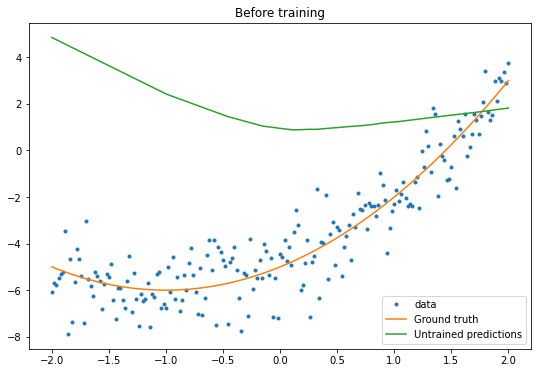

In [31]:
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend();

- 学習処理

In [32]:
variables = model.variables

optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(1000):
    with tf.GradientTape() as tape:
        prediction = model(x)
        error = (y-prediction)**2
        mean_error = tf.reduce_mean(error) # MSE

    gradient = tape.gradient(mean_error, variables)
    optimizer.apply_gradients(zip(gradient, variables))

    if step % 100 == 0:
        print(f'Mean squared error: {mean_error.numpy():0.3f}')

Mean squared error: 42.523
Mean squared error: 1.111
Mean squared error: 1.087
Mean squared error: 1.074
Mean squared error: 1.066
Mean squared error: 1.060
Mean squared error: 1.056
Mean squared error: 1.053
Mean squared error: 1.050
Mean squared error: 1.048


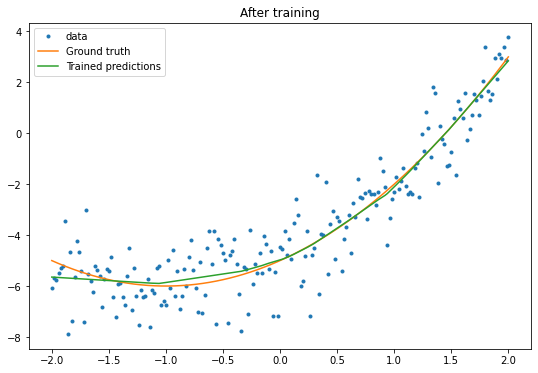

In [33]:
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

- ラップされた学習
  - 先ほどの例はスクラッチで構築する場合で、実際はもっと高レベルのAPIで実現できる。

In [34]:
new_model = Model(64)

In [35]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

model.save('./my_model')

INFO:tensorflow:Assets written to: ./my_model\assets


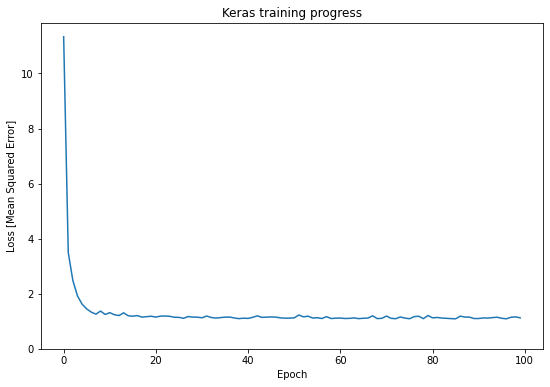

In [36]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

In [37]:
# 以上